In [22]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

def get_specific_tiki_categories(delay=0.6, max_depth=2):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }

    root_categories = [
        {"Tên danh mục": "Điện Thoại - Máy Tính Bảng", "URL": "https://tiki.vn/dien-thoai-may-tinh-bang/c1789"},
        {"Tên danh mục": "Thiết Bị Số - Phụ Kiện Số", "URL": "https://tiki.vn/thiet-bi-so-phu-kien-so/c1815"},
        {"Tên danh mục": "Laptop - Máy Vi Tính - Linh kiện", "URL": "https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846"},
        {"Tên danh mục": "Máy Ảnh - Máy Quay Phim", "URL": "https://tiki.vn/may-anh-may-quay-phim/c1801"},
    ]

    all_cats, visited = [], set()

    def crawl_category(url, parent_name, depth):
        """Đệ quy lấy danh mục con trong khối iNVZwz"""
        if depth > max_depth or url in visited:
            return
        visited.add(url)

        try:
            res = requests.get(url, headers=headers, timeout=10)
            res.raise_for_status()
        except Exception as e:
            print(f"⚠️ Lỗi khi truy cập {url}: {e}")
            return

        soup = BeautifulSoup(res.text, "html.parser")

        # ✅ Lấy container chứa danh mục con
        container = soup.find("div", class_="sc-9f1e84db-1 iNVZwz")
        if not container:
            print(f"⚠️ Không tìm thấy danh mục con trong {url}")
            return

        found = False
        for a_tag in container.find_all("a", href=True):
            href = a_tag["href"]
            name = a_tag.find("div", class_="sc-9f1e84db-5 cZlEPY")
            if not name:
                continue
            name = name.get_text(strip=True)
            match = re.search(r"/c(\d+)", href)
            if not match:
                continue

            found = True
            cat_id = int(match.group(1))
            cat_url = href if href.startswith("http") else f"https://tiki.vn{href}"

            all_cats.append({
                "Tên danh mục": name,
                "Category ID": cat_id,
                "Cấp độ": depth,
                "Danh mục cha": parent_name,
                "Đường dẫn": cat_url
            })

            # 🔁 Nếu còn cấp, tiếp tục crawl
            if depth < max_depth:
                time.sleep(delay)
                crawl_category(cat_url, parent_name=name, depth=depth + 1)

        if not found:
            print(f"⚠️ Không có danh mục con hợp lệ trong {url}")

    # 🔍 Bắt đầu quét
    for root in root_categories:
        print(f"\n🔍 Đang quét: {root['Tên danh mục']}")
        crawl_category(root["URL"], parent_name=root["Tên danh mục"], depth=1)

    df = pd.DataFrame(all_cats).drop_duplicates(subset=["Category ID"]).reset_index(drop=True)
    print(f"\n✅ Hoàn tất: Thu thập được {len(df)} danh mục con (tối đa {max_depth} cấp).")
    return df


In [ ]:

# # --- Lấy danh mục ---
# categories_df = get_specific_tiki_categories()
# if categories_df.empty:
#     print("Không lấy được danh mục. Dừng chương trình.")

# categories_df.to_csv("tiki_categories.csv", index=False, encoding="utf-8-sig")
# print("💾 Danh mục đã lưu vào tiki_categories.csv")


In [37]:
# ====================================
# 2️⃣ SCRAPER DÙNG API TIKI (TỐI ƯU)
# ====================================
class TikiCategoryScraper:
    def __init__(self, category_id: int, category_name: str, limit: int = 40):
        self.base_url = "https://tiki.vn/api/personalish/v1/blocks/listings"
        self.detail_url = "https://tiki.vn/api/v2/products/{pid}?spid={spid}"
        self.category_id = category_id
        self.category_name = category_name
        self.limit = limit
        self.headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/120.0.0.0 Safari/537.36"
            ),
            "Referer": "https://tiki.vn/",
            "Accept": "application/json, text/plain, */*"
        }
        self.products = []
        self.seller_cache = {}  # ⚙️ Cache seller_id → seller_name

    # -----------------------------
    def fetch_page(self, page: int):
        """Lấy danh sách sản phẩm trong 1 trang"""
        params = {"category": self.category_id, "page": page, "limit": self.limit}
        try:
            r = requests.get(self.base_url, headers=self.headers, params=params, timeout=10)
            r.raise_for_status()
            data = r.json()  # parse JSON trả về

            # In ra dạng đẹp, có thụt dòng để dễ xem
            #print(json.dumps(data, indent=2, ensure_ascii=False))

            return data
        except Exception as e:
            print(f"⚠️ Lỗi khi tải trang {page}: {e}")
            return None

    # -----------------------------
    def fetch_seller_name(self, pid: int, spid: int, retries=5, backoff=1.5):
        cache_key = f"{pid}_{spid}"
        if cache_key in self.seller_cache:
            return self.seller_cache[cache_key]

        for attempt in range(1,retries+1):
            try:
                url = self.detail_url.format(pid=pid, spid=spid)
                res = requests.get(url, headers=self.headers, timeout=10)
                res.raise_for_status()
                data = res.json()
                seller = data.get("current_seller") or data.get("seller") or {}
                name = seller.get("name", "N/A")
                if name != "N/A":
                    self.seller_cache[cache_key] = name
                    return name
            except Exception as e:
                sleep_time = backoff * attempt + random.uniform(0.2, 1.0)
                time.sleep(sleep_time)
        return "N/A"


    # -----------------------------
    def scrape(self):
        """Tự động lấy tất cả sản phẩm trong danh mục"""
        print(f"\n🔍 Đang thu thập danh mục: {self.category_name} (ID={self.category_id})")

        page = 1
        total = 0

        while True:
            print(f"📄 Trang {page} ...")
            data = self.fetch_page(page)
            if not data or "data" not in data or not data["data"]:
                print("🚩 Hết dữ liệu hoặc lỗi API, dừng lại.")
                break

            items = []
            for item in data["data"]:
                pid = item.get("id")
                spid = item.get("seller_product_id")
                url = f"https://tiki.vn/{item.get('url_path', '')}"
                category = (
                    item.get("visible_impression_info", {})
                        .get("amplitude", {})
                        .get("primary_category_name", "N/A")
                )

                items.append({
                    "product_id": pid,
                    "seller_product_id": spid,
                    "url": url,
                    "product_name": item.get("name", "N/A"),
                    "sold": (item.get("quantity_sold") or {}).get("value", 0),
                    "review_count": item.get("review_count", 0),
                    "rating": item.get("rating_average", 0.0),
                    "price": item.get("price", 0),
                    "currency": "VND",  # Tiki luôn dùng VNĐ
                    "categories": category,
                    "sku": item.get("sku", "N/A"),
                    "brand": item.get("brand_name", "N/A"),
                })

            # ⚡ Lấy seller_name song song (đa luồng)
            with ThreadPoolExecutor(max_workers=10) as executor:
                futures = {
                    executor.submit(
                        self.fetch_seller_name, it["product_id"], it["seller_product_id"]
                    ): it
                    for it in items
                }

                for future in as_completed(futures):
                    it = futures[future]
                    it["seller_name"] = future.result()
                    self.products.append(it)


            total += len(items)
            print(f"✅ Trang {page}: lấy được {len(items)} sản phẩm (tổng {total})")

            # Nếu ít hơn limit → hết sản phẩm
            if len(items) < self.limit:
                print("🏁 Đã lấy hết sản phẩm trong danh mục này.")
                break

            page += 1
            time.sleep(1.2)  # nghỉ nhẹ tránh bị rate limit

        print(f"🎯 Tổng cộng lấy được {len(self.products)} sản phẩm.")
        return self.products

# ======================================
# 3️⃣ CHƯƠNG TRÌNH CHÍNH
# ======================================
# def main():
#     categories_df = pd.read_csv("tiki_categories.csv")
#     all_products = []
#     # --- Lặp qua từng danh mục và lấy sản phẩm ---
#     for _, row in categories_df.iterrows():
#         cat_id = row["Category ID"]
#         cat_name = row["Tên danh mục"]

#         scraper = TikiCategoryScraper(category_id=cat_id, category_name=cat_name)
#         products = scraper.scrape()
#         all_products.extend(products)

#     # --- Lưu kết quả ---
#     df_all = pd.DataFrame(all_products)
#     df_all.to_csv("tiki_tech_products.csv", index=False, encoding="utf-8-sig")
#     print("\n🎉 Hoàn tất! Đã lưu toàn bộ dữ liệu vào tiki_all_products.csv")


# if __name__ == "__main__":
#     main()


In [38]:
categories_df = pd.read_csv("tiki_categories.csv")
all_products = []
# --- Lặp qua từng danh mục và lấy sản phẩm ---
for _, row in categories_df.iterrows():
    cat_id = row["Category ID"]
    cat_name = row["Tên danh mục"]

    scraper = TikiCategoryScraper(category_id=cat_id, category_name=cat_name)
    products = scraper.scrape()
    all_products.extend(products)

# --- Lưu kết quả ---
df_all = pd.DataFrame(all_products)
df_all.to_csv("tiki_tech_products(2).csv", index=False, encoding="utf-8-sig")
print("\n🎉 Hoàn tất! Đã lưu toàn bộ dữ liệu vào tiki_all_products.csv")


🔍 Đang thu thập danh mục: Điện thoại Smartphone (ID=1795)
📄 Trang 1 ...
✅ Trang 1: lấy được 40 sản phẩm (tổng 40)
📄 Trang 2 ...
✅ Trang 2: lấy được 40 sản phẩm (tổng 80)
📄 Trang 3 ...
✅ Trang 3: lấy được 40 sản phẩm (tổng 120)
📄 Trang 4 ...
✅ Trang 4: lấy được 40 sản phẩm (tổng 160)
📄 Trang 5 ...
✅ Trang 5: lấy được 3 sản phẩm (tổng 163)
🏁 Đã lấy hết sản phẩm trong danh mục này.
🎯 Tổng cộng lấy được 163 sản phẩm.

🔍 Đang thu thập danh mục: Máy tính bảng (ID=1794)
📄 Trang 1 ...
✅ Trang 1: lấy được 17 sản phẩm (tổng 17)
🏁 Đã lấy hết sản phẩm trong danh mục này.
🎯 Tổng cộng lấy được 17 sản phẩm.

🔍 Đang thu thập danh mục: Máy đọc sách (ID=28856)
📄 Trang 1 ...
✅ Trang 1: lấy được 18 sản phẩm (tổng 18)
🏁 Đã lấy hết sản phẩm trong danh mục này.
🎯 Tổng cộng lấy được 18 sản phẩm.

🔍 Đang thu thập danh mục: Điện thoại phổ thông (ID=1796)
📄 Trang 1 ...
✅ Trang 1: lấy được 13 sản phẩm (tổng 13)
🏁 Đã lấy hết sản phẩm trong danh mục này.
🎯 Tổng cộng lấy được 13 sản phẩm.

🔍 Đang thu thập danh mục:

In [1]:
# import pandas as pd
# import numpy as np

# # === 1️⃣ Đọc file CSV ===
# df_main = pd.read_csv("tiki_tech_products(2).csv", dtype={"product_id": str})
# df_backup = pd.read_csv("tiki_tech_products.csv", dtype={"product_id": str})


# # === 3️⃣ Tạo từ điển product_id → seller_name từ backup (chỉ lấy giá trị hợp lệ)
# backup_dict = (
#     df_backup.dropna(subset=["seller_name"])
#     .set_index("product_id")["seller_name"]
#     .to_dict()
# )

# # === 4️⃣ Cập nhật seller_name trong df_main nếu đang thiếu (NaN)
# mask_missing = df_main["seller_name"].isna()
# df_main.loc[mask_missing, "seller_name"] = (
#     df_main.loc[mask_missing, "product_id"].map(backup_dict)
# )

# # === 5️⃣ Ghi ra file mới ===
# df_main.to_csv("tiki_tech_products_merged.csv", index=False, encoding="utf-8-sig")

# # === 6️⃣ Thống kê số dòng được cập nhật ===
# updated_count = df_main["seller_name"].notna().sum() - (
#     df_main["seller_name"].replace(backup_dict).notna().sum()
# )
# print(f"✅ Đã cập nhật {mask_missing.sum()} sản phẩm có seller_name từ file backup!")
# print(f"📄 File mới: tiki_tech_products_merged.csv ({len(df_main)} dòng)")


✅ Đã cập nhật 3 sản phẩm có seller_name từ file backup!
📄 File mới: tiki_tech_products_merged.csv (7336 dòng)


In [3]:
df = pd.read_csv("tiki_tech_products.csv")

In [10]:
print(df.isnull().sum())


product_id           0
seller_product_id    0
url                  0
product_name         0
sold                 0
review_count         0
rating               0
price                0
currency             0
categories           0
sku                  0
brand                1
seller_name          0
dtype: int64


In [12]:
df = df.dropna()
print(df.isnull().sum())

product_id           0
seller_product_id    0
url                  0
product_name         0
sold                 0
review_count         0
rating               0
price                0
currency             0
categories           0
sku                  0
brand                0
seller_name          0
dtype: int64


In [6]:
duplicates = df.duplicated().sum()
print("Số dòng trùng hoàn toàn:", duplicates)


Số dòng trùng hoàn toàn: 6


In [9]:
df = df.drop_duplicates()
duplicates = df.duplicated().sum()
print("Số dòng trùng hoàn toàn:", duplicates)



Số dòng trùng hoàn toàn: 0


In [16]:
# Dòng dữ liệu không hợp lệ: giá <= 0 hoặc rating nằm ngoài khoảng [0, 5]
invalid = df[(df['price'] <= 0) | ((df['rating'] > 5) | (df['rating'] < 0))]

print(f"Số dòng dữ liệu không hợp lệ: {len(invalid)}")


Số dòng dữ liệu không hợp lệ: 0


In [17]:
print(df.dtypes)

product_id             int64
seller_product_id      int64
url                   object
product_name          object
sold                   int64
review_count           int64
rating               float64
price                  int64
currency              object
categories            object
sku                    int64
brand                 object
seller_name           object
dtype: object


In [18]:
df['price'] = df['price'].astype(float)
print(df['price'].dtype)

float64


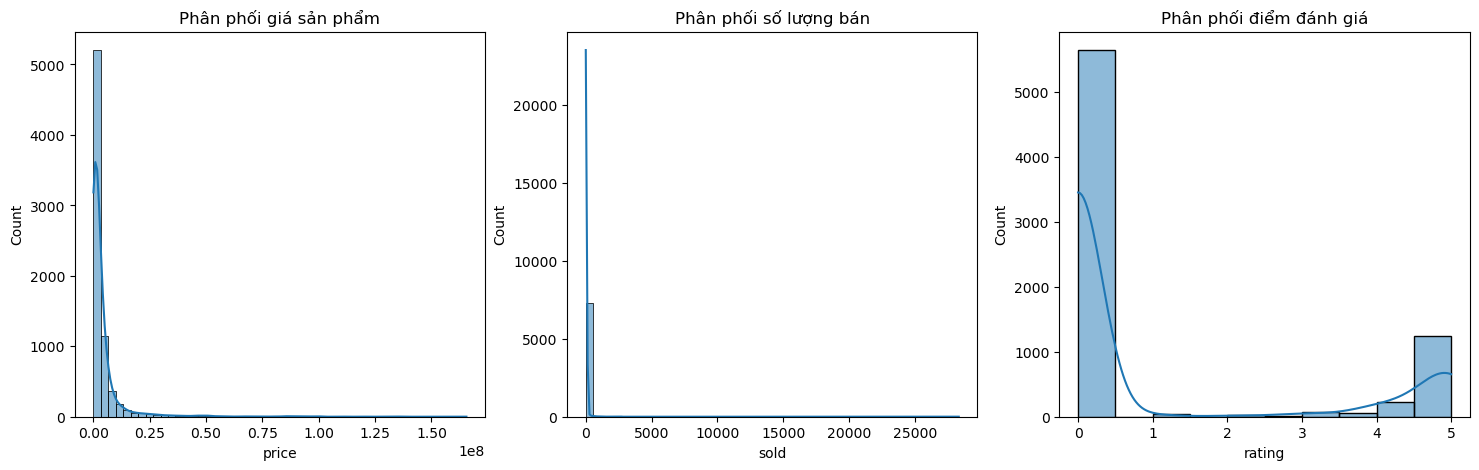

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df['price'], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Phân phối giá sản phẩm")

sns.histplot(df['sold'], bins=50, ax=axes[1], kde=True)
axes[1].set_title("Phân phối số lượng bán")

sns.histplot(df['rating'], bins=10, ax=axes[2], kde=True)
axes[2].set_title("Phân phối điểm đánh giá")

plt.show()


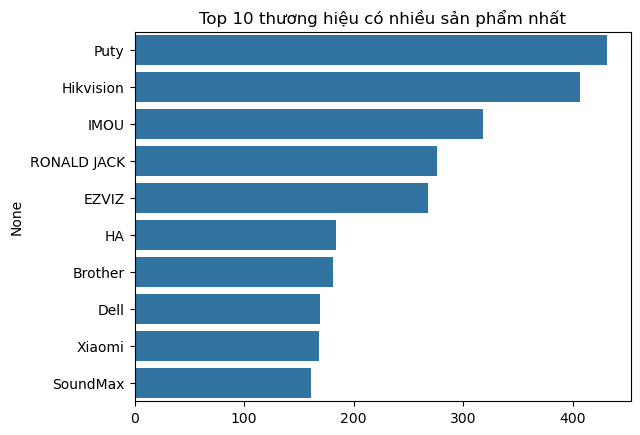

In [32]:
top_brands = df['brand'].value_counts().head(10)
sns.barplot(y=top_brands.index, x=top_brands.values)
plt.title("Top 10 thương hiệu có nhiều sản phẩm nhất")
plt.show()


Text(0.5, 1.0, 'Top 10 người bán có nhiều sản phẩm nhất')

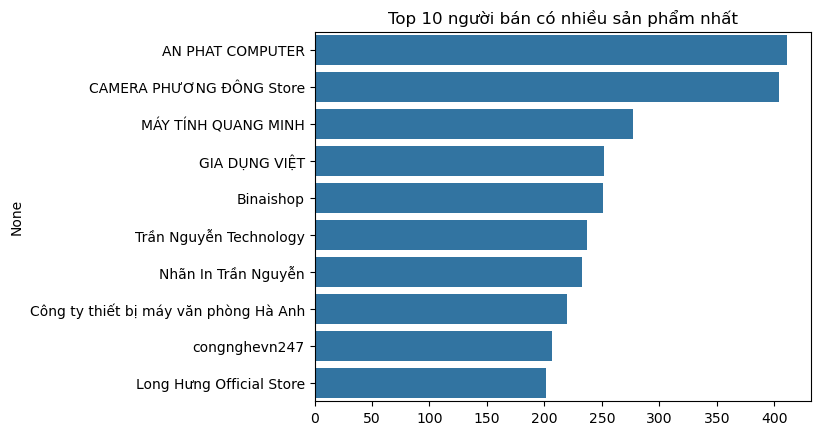

In [33]:
top_sellers = df['seller_name'].value_counts().head(10)
sns.barplot(y=top_sellers.index, x=top_sellers.values)
plt.title("Top 10 người bán có nhiều sản phẩm nhất")

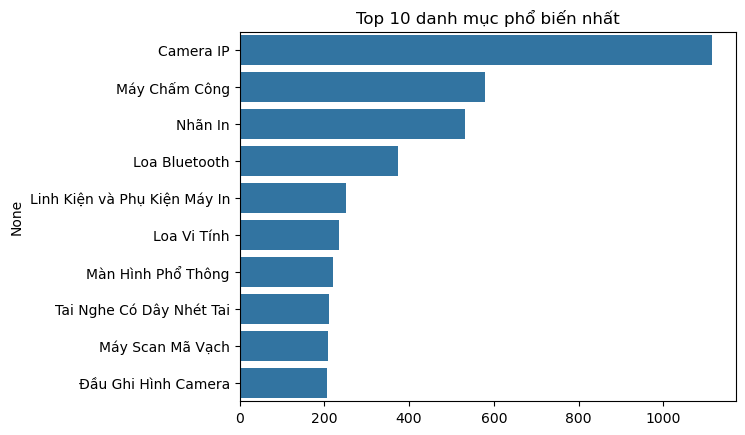

In [34]:
df['main_category'] = df['categories'].apply(lambda x: x.split('>')[0] if pd.notna(x) else 'Unknown')
top_categories = df['main_category'].value_counts().head(10)

sns.barplot(y=top_categories.index, x=top_categories.values)
plt.title("Top 10 danh mục phổ biến nhất")
plt.show()


                  seller_name   sold
301              Tiki Trading  81293
64             Công Nghệ Việt  18346
361  iCybernet Official Store  11365
9                   AMA Store   8695
29                  Binaishop   5045
251          TAKA Phụ Kiện Số   4338
37   CAMERA PHƯƠNG ĐÔNG Store   3943
105                  HDC Home   2382
333       Viễn thông Hà Nhung   2123
274                Techmorevn   1643


C:\Users\Thuy Quynh\AppData\Local\Temp\ipykernel_2864\1943590467.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_seller, x='sold', y='seller_name', palette='viridis')


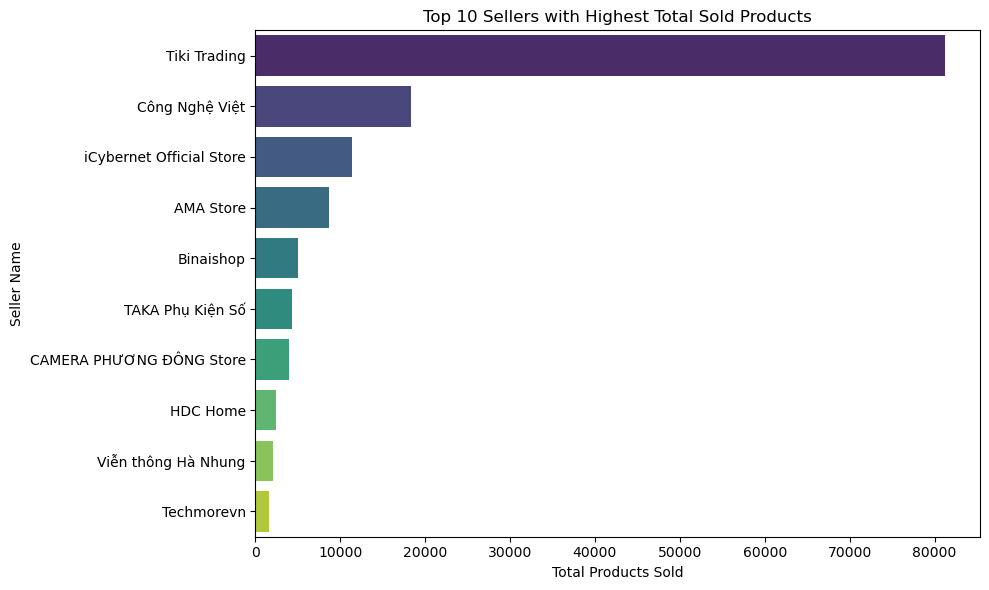

In [35]:
top_seller = (
    df.groupby('seller_name', as_index=False)['sold']
      .sum()
      .sort_values(by='sold', ascending=False)
)

top10_seller = top_seller.head(10)
print(top10_seller)
plt.figure(figsize=(10,6))
sns.barplot(data=top10_seller, x='sold', y='seller_name', palette='viridis')
plt.title('Top 10 Sellers with Highest Total Sold Products')
plt.xlabel('Total Products Sold')
plt.ylabel('Seller Name')
plt.tight_layout()
plt.show()

In [19]:
df.to_csv("tiki__products.csv", index=False, encoding='utf-8-sig')